# Sentiment Analysis of Financial News

The data source is available at [Kaggle](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download). 

**Context**: This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

In [40]:
import time
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

import transformers # transformers library by Hugging Face
from transformers import MarianMTModel, pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


# from torchtext.vocab import GloVe
# from torchtext.data.utils import get_tokenizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,  precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from textblob import TextBlob

import string

import pickle
import joblib

We first do a GPU check.

In [ ]:
print(torch.version.cuda)
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [ ]:
os.getcwd()

In [ ]:
data = pd.read_csv("D:\Data\PyCharmProjects\MAS-sentiment-analysis\data/financial_news.csv", 
                   names=['sentiment', 'news'])
data.sample(10)

In [ ]:
data.info()

Our dataframe consists of 4,846 rows with just two columns i.e sentiment and news.

## Data Analysis

In [ ]:
value_counts = data['sentiment'].value_counts(normalize=True) * 100  # Get percentages
count_with_percentages = data['sentiment'].value_counts().to_frame('counts')  # Get counts
count_with_percentages['percentage'] = round(value_counts, 2)  # Add percentages to the DataFrame

print(count_with_percentages)

In [ ]:
def pie_plot():
    # Calculate counts and percentages
    value_counts = data['sentiment'].value_counts()
    percentages = value_counts / value_counts.sum() * 100
    
    # Create labels with both values and percentages
    labels = [f'{label}: {count}' for label, count in zip(value_counts.index, value_counts)]
    
    # Define the explode parameter to separate the "negative" slice
    explode = [0.05 if label == 'negative' else 0 for label in value_counts.index]
    
    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, explode=explode)
    plt.title('Sentiment Distribution on Financial Dataset')
    plt.show()

In [ ]:
pie_plot()

## Data Preprocessing

In [ ]:
# Encode the sentiment labels to integers
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

With the encoder, we have 
- negative = 0, 
- neutral = 1, 
- positive = 2.

In [ ]:
data.sample(50)

In [ ]:
# Split the data into features (X) and target (y)
X = data['news'].values
y = data['sentiment_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

## 1. LSTM Model

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.unk_idx = self.vocab.stoi.get('<unk>', len(self.vocab.stoi))
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokenized = [self.vocab.stoi.get(token, self.unk_idx) for token in self.tokenizer(text)]
        tokenized = [idx if idx < len(self.vocab.stoi) else 0 for idx in tokenized] 

        # # Debugging: Check if any index is out of range
        # if torch.any(tokenized_tensor >= len(self.vocab.stoi)):
        #     print(f"Out-of-range index in text at index {idx}: {text}")
        #     print(f"Tokenized indices: {tokenized_tensor}")
        #     print(f"Vocabulary size: {len(self.vocab.stoi)}")

        return torch.tensor(tokenized, dtype=torch.long), label

In [ ]:
# Initialize the GloVe vocabulary and tokenizer
glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe vectors
tokenizer = get_tokenizer("basic_english")

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, glove, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, glove, tokenizer)

# Define a collate function to pad sequences
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last hidden state
        out = self.fc(lstm_out)
        return out

In [ ]:
# vocab_size = len(glove.stoi)
vocab_size = 768
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Three sentiment classes

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Initialize the embeddings with GloVe vectors
model.embedding.weight.data.copy_(glove.vectors)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
%%time

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


In [ ]:
# # Load the lstm model from memory.
# 
# # Assuming we have the LSTMModel class definition from before
# 
# # 1. Create the model architecture
# model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
# 
# # 2. Load the saved state dictionary
# model.load_state_dict(torch.load('lstm_model.pth'))
# 
# # 3. Set the model to evaluation mode
# model.eval()


In [ ]:
# Assuming you have a test DataLoader named `test_loader`

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient computation as we are not training
with torch.no_grad():
    all_predictions = []
    all_labels = []

    # 3. Iterate over the test data
    for texts, labels in test_loader:
        # Forward pass to get predictions
        outputs = model(texts)
        
        # Get the predicted class by finding the index with the max value
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and labels for metric computation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

In [ ]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Assuming you have a test DataLoader named `test_loader`
# and the model is already trained and loaded.

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient computation
all_predictions = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        # Forward pass
        outputs = model(texts)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 4. Display the confusion matrix using matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for LSTM Model")
plt.show()

In [ ]:
# Assuming `model` is your trained model
torch.save(model.state_dict(), './models/lstm/lstm_model.pth')

## 2. DistilBERT & Logistic Regression

The DistilBERT processes the input sentence and passes on the relevant information to the Logistic Regression Model for sentiment classification. It is BERT lite. 

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# tokenize all the reviews in column 0 of the dataframe "df"
tokenized = data['news'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
def visualized_sentence_embedding(df: pd.DataFrame, tokenized: pd.Series) -> pd.DataFrame:
    """
    Function to see tokens and embeddings of the first review in df.
    """
    tokens = data.iloc[0,1].split(" ")
    tokens.insert(0, "CLS")
    tokens.append("SEP")
    assert len(tokens) == len(tokenized[0])
    token_embeddings = list(zip(tokens, tokenized[0]))
    df_token_embeddings = pd.DataFrame(token_embeddings, columns=["Tokens", "Embeddings"])
    return df_token_embeddings

In [ ]:
df_token_embeddings = visualized_sentence_embedding(data, tokenized)
df_token_embeddings.head(500)

We pad to ensure that each sentence in the news column all have the same number of tokens.

In [ ]:
max_len = 0
max_len = max([len(i) for i in tokenized.values if len(i) > max_len])
padded_token_embeddings = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(max_len)
print(padded_token_embeddings.shape)

We create a separate variable called attention_mask. This variable indicates which tokens should be attended to by the model and which tokens should be ignored (masked) during processing. By setting the attention mask to 1 for the real tokens and 0 for the padding tokens, we can tell BERT to ignore the padding when processing the input. This helps to improve the accuracy of the model's predictions.

In [ ]:
attention_mask = np.where(padded_token_embeddings != 0, 1, 0)
assert attention_mask.shape == padded_token_embeddings.shape
print(attention_mask.shape)

Model inputs

In [ ]:
# move model and data to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()

model.to(device)  # Move the model to the GPU

In [ ]:
batch_size = 8  # Adjust this to a smaller number that fits your GPU memory

input_ids = torch.tensor(padded_token_embeddings)
attention_mask = torch.tensor(attention_mask)

# Assuming you have your input_ids and attention_mask tensors
input_ids_batches = torch.split(input_ids, batch_size)
attention_mask_batches = torch.split(attention_mask, batch_size)

In [ ]:
last_hidden_states = []
start = time.time()

with torch.no_grad():
    for input_ids_batch, attention_mask_batch in zip(input_ids_batches, attention_mask_batches):
        outputs = model(input_ids_batch.to(device), attention_mask=attention_mask_batch.to(device))
        last_hidden_states.append(outputs[0].cpu())  # Move outputs to CPU to free GPU memory

end = time.time()
print(round((end - start)/60, 2), 'minutes') # time in minutes
last_hidden_states = torch.cat(last_hidden_states, dim=0)

In [ ]:
last_hidden_states.shape

In [ ]:
last_hidden_states[:,0,:].numpy()

In [ ]:
if not os.path.exists("./models/DB_n_LR/"): # check if directory exists, else, create it!!!
    os.mkdir("./models/DB_n_LR/")
# save trained DistilBERT model
torch.save(model.state_dict(), './models/DB_n_LR/DB.pth')

In [ ]:
# input_ids = torch.tensor(padded_token_embeddings)
# attention_mask = torch.tensor(attention_mask)
# 
# # moving data to GPU
# input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

In [ ]:
# start = time.time()
# 
# # !set CUDA_LAUNCH_BLOCKING=1
# 
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)
# 
# end = time.time()
# print(end - start) # time in seconds

In [ ]:
# extracting features and labels
features = last_hidden_states[:,0,:].numpy()
print(features.shape)

In [ ]:
labels = data['sentiment_encoded']
assert len(features) == len(labels)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

## Logistic Regression

In [ ]:
lr_clf = LogisticRegression(C=5, max_iter=1000) # baseline LR model
lr_clf.fit(train_features, train_labels)

In [ ]:
# see how our trained LR model performs on the test set
lr_clf.score(test_features, test_labels)

### Hyperparameter tuning of the LR model.

In [ ]:
lr = LogisticRegression(random_state=42)

params_lr = {
    'penalty': ['l1','l2', 'elasticnet'],
    'l1_ratio' : np.arange(0., 1.0, 0.1),
    'solver' : ['saga'],
    'tol': [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'C' : [1, 5, 10, 100],
}

# Instantiate the grid search model
grid_search_lr = GridSearchCV(estimator=lr,
                           param_grid=params_lr,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [ ]:
%%time
grid_search_lr.fit(train_features, train_labels)

In [ ]:
grid_search_lr.best_score_, grid_search_lr.best_estimator_

In [35]:
lr_best = LogisticRegression(C=1, l1_ratio=0.7, penalty='elasticnet',
                    random_state=42, solver='saga', tol=0.01)

In [36]:
%%time

start = time.time()

lr_best.fit(train_features, train_labels)

# see how our trained LR model performs on the test set
print('Best LR model accuracy:', lr_best.score(test_features, test_labels))

end = time.time()
print(round((end - start)/60, 2), 'minutes') # time in minutes
print(round((end - start)/1, 2), 'seconds') # time in minutes

Best LR model accuracy: 0.790721649484536
0.19 minutes
11.64 seconds
CPU times: total: 10.4 s
Wall time: 11.6 s


## LR evaluation

In [37]:
# Predict on the test set
y_pred = lr_best.predict(test_features)
# train_features, test_features, train_labels, test_labels 

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

Accuracy: 0.7907
Precision: 0.7855
Recall: 0.7907
F1 Score: 0.7849

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       110
           1       0.82      0.91      0.86       571
           2       0.74      0.63      0.68       289

    accuracy                           0.79       970
   macro avg       0.76      0.72      0.73       970
weighted avg       0.79      0.79      0.78       970



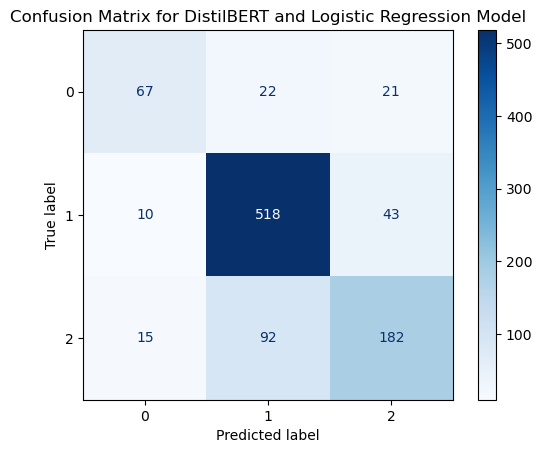

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_best.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for DistilBERT and Logistic Regression Model')
plt.show()

saving the model 

In [ ]:
# Save the model
with open('./models/DB_n_LR/logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(lr_best, file)

In [ ]:
joblib.dump(lr_best, './models/DB_n_LR/logistic_regression_model.joblib')

To load the model:

In [ ]:
# with pickle
with open('./models/DB_n_LR/logistic_regression_model.pkl', 'rb') as file:
    lr_model = pickle.load(file)

In [ ]:
# Load the model with joblib
lr_model = joblib.load('logistic_regression_model.joblib')

# Pretrained Transformer

In [ ]:
# load sentiment analysis model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_classifier = pipeline("sentiment-analysis", model= model_name)

In [ ]:
def analyze_sentiment(text, classifier):
    """
    function to perform sentiment analysis on a text using a model
    """
    result = classifier(text)
    return result

In [ ]:
%%time
# perform sentiment analysis on reviews and store results in new column
news = data["news"]
results = news.apply(lambda reviews: analyze_sentiment(reviews,sentiment_classifier))
data["sentiment_transformer"] = results.apply(lambda results: results[0]['label'])

In [ ]:
data["sentiment_transformer_score"] = results.apply(lambda results: results[0]['score'])

In [ ]:
data["sent_trans_NEUTRAL_SCORE"] = data["sentiment_transformer_score"].apply(lambda x: "neutral" if x < 0.989 else np.nan)

In [ ]:
data.info()

In [ ]:
# results
data.to_csv("D:\\Data\\PyCharmProjects\/MAS-sentiment-analysis/data/sentiment_transformer.csv")

In [ ]:
data_updated = pd.read_csv("D:\\Data\\PyCharmProjects\/MAS-sentiment-analysis/data/sentiment_transformer_update_v1.csv", index_col=0)

In [ ]:
data_updated['combine'].value_counts()

In [ ]:
data['sentiment'].value_counts()

In [ ]:
data_updated.info()

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(data_updated["sentiment"], data_updated["combine"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=data_updated["sentiment"].unique())
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Pretrained Transformer')
plt.show()

In [ ]:
# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(data_updated["sentiment"], data_updated["combine"]))

## Naive Bayes Model

In [48]:
# Preprocess the text data
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [57]:
data['processed_news'] = data['news'].apply(preprocess_text)

In [58]:
# Convert text data into numerical features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_news'])
y = data['sentiment']

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Train a Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [61]:
model.score(X_test, y_test)

0.7072164948453609

In [66]:
# Predict the sentiments on the test set
y_pred = model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7072
Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.53      0.54       110
     neutral       0.78      0.81      0.79       571
    positive       0.62      0.58      0.60       289

    accuracy                           0.71       970
   macro avg       0.65      0.64      0.64       970
weighted avg       0.70      0.71      0.70       970



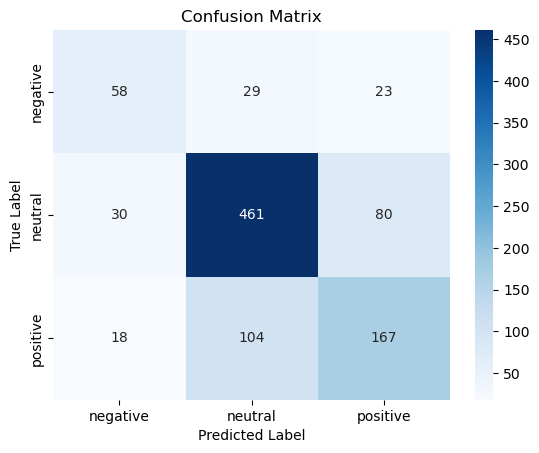

In [67]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Hyperparameter tuning for naive bayes

In [68]:
# Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0]}

In [70]:
%%time
# Initialize the model
nb_model = MultinomialNB()

# Perform Grid Search

grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

Best alpha: 2.0
Best cross-validation accuracy: 0.6845
CPU times: total: 844 ms
Wall time: 1.21 s


In [71]:
print(grid_search.best_estimator_)

MultinomialNB(alpha=2.0)


In [72]:
# Train the model with the best alpha
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best alpha: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Test set accuracy with best alpha: 0.7196
Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.40      0.51       110
     neutral       0.75      0.88      0.81       571
    positive       0.65      0.53      0.59       289

    accuracy                           0.72       970
   macro avg       0.70      0.60      0.63       970
weighted avg       0.71      0.72      0.71       970



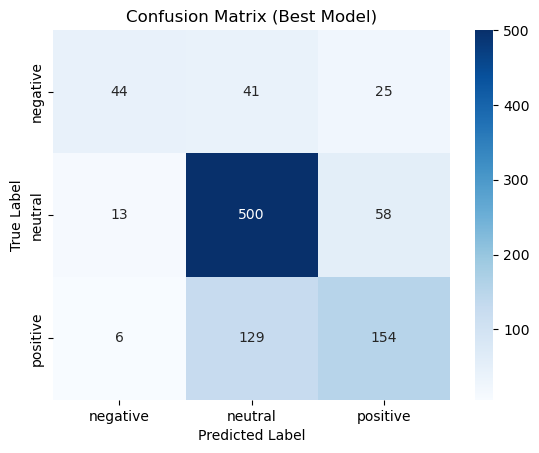

In [73]:
# Generate the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Model)')
plt.show()